In [ ]:
# Emotion Classification using FER-2013 Dataset
# This notebook implements a CNN model for facial emotion recognition

import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'dataset_name': 'fer2013',
    'data_dir': './data',  # Local data directory
    'train_dir': './data/train',
    'test_dir': './data/test',
    'batch_size': 64,
    'num_epochs': 20,
    'learning_rate': 0.001,
    'image_size': 48
}

# Create data directory if it doesn't exist
os.makedirs(CONFIG['data_dir'], exist_ok=True)

print("Configuration loaded successfully!")
print(f"Data directory: {CONFIG['data_dir']}")
print("Note: Please ensure the FER-2013 dataset is downloaded and placed in the data directory")

Using Colab cache for faster access to the 'fer2013' dataset.
Path to dataset files: /kaggle/input/fer2013


In [ ]:
# Set up dataset paths using configuration
train_folder = CONFIG['train_dir']
test_folder = CONFIG['test_dir']

print(f"Train folder: {train_folder}")
print(f"Test folder: {test_folder}")

# Check if dataset exists
if not os.path.exists(train_folder):
    print(f"Warning: Train folder {train_folder} does not exist!")
    print("Please download the FER-2013 dataset and extract it to the data directory")
else:
    print("Train folder found successfully!")

In [ ]:
# Dataset exploration and analysis
import os
from collections import Counter

# Check if train folder exists before proceeding
if os.path.exists(train_folder):
    root = train_folder
    counts = {cls: len(os.listdir(os.path.join(root, cls))) for cls in os.listdir(root)}
    print("Class distribution in training set:")
    for emotion, count in counts.items():
        print(f"{emotion}: {count} images")
    
    total_images = sum(counts.values())
    print(f"\nTotal training images: {total_images}")
else:
    print("Train folder not found. Please ensure the dataset is properly downloaded and extracted.")

In [ ]:
# Visualize sample images from the dataset
import cv2
import matplotlib.pyplot as plt
import os

if os.path.exists(train_folder):
    # Display sample images from each emotion class
    emotions = os.listdir(train_folder)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, emotion in enumerate(emotions[:7]):  # Show 7 emotions
        emotion_path = os.path.join(train_folder, emotion)
        if os.path.isdir(emotion_path):
            files = os.listdir(emotion_path)
            if files:
                img_file = files[0]  # Take first image
                img_path = os.path.join(emotion_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    axes[i].imshow(img, cmap="gray")
                    axes[i].set_title(f"{emotion}")
                    axes[i].axis("off")
    
    # Hide unused subplot
    axes[7].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Cannot visualize images: Train folder not found.")


{'surprise': 3171, 'fear': 4097, 'angry': 3995, 'neutral': 4965, 'sad': 4830, 'disgust': 436, 'happy': 7215}


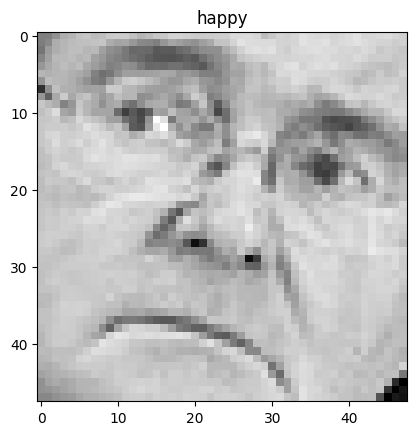

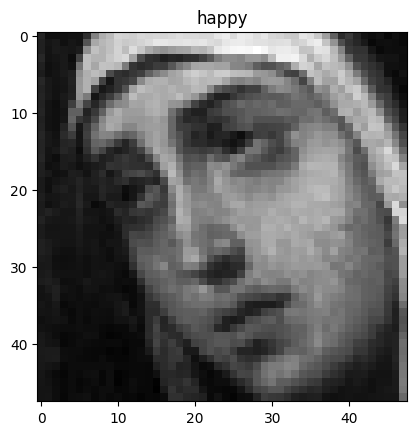

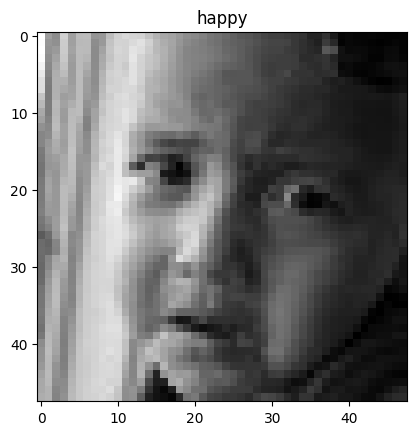

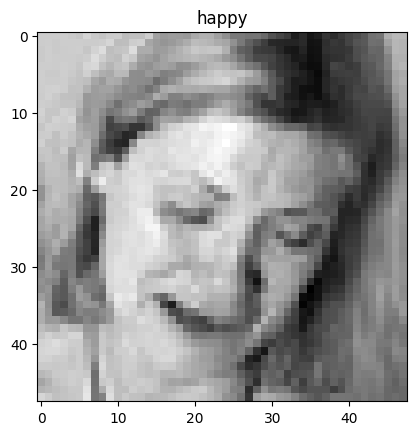

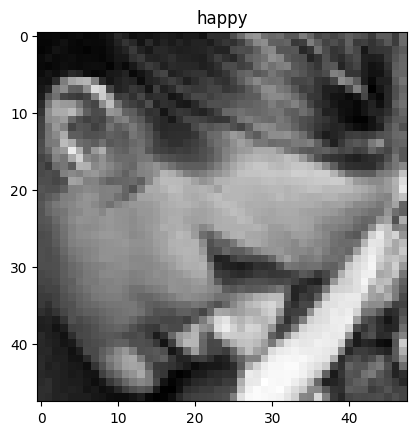

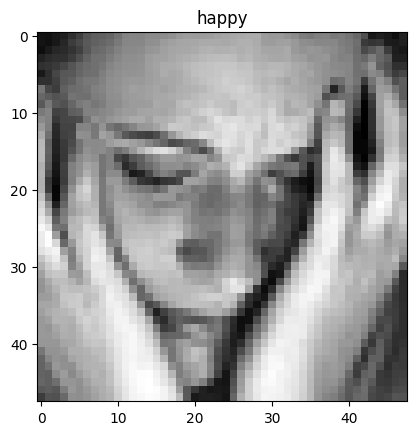

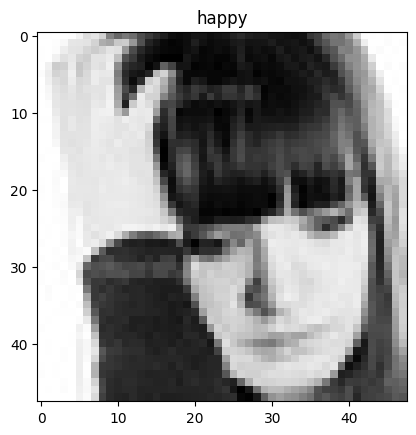

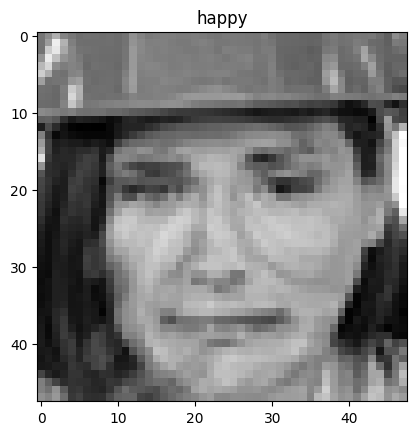

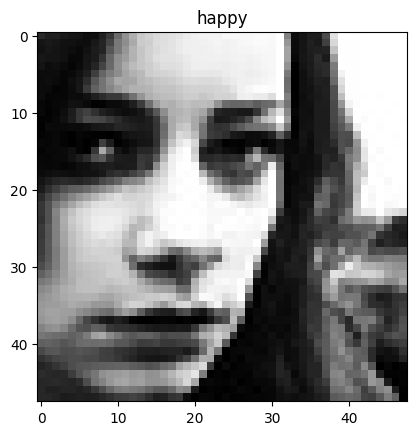

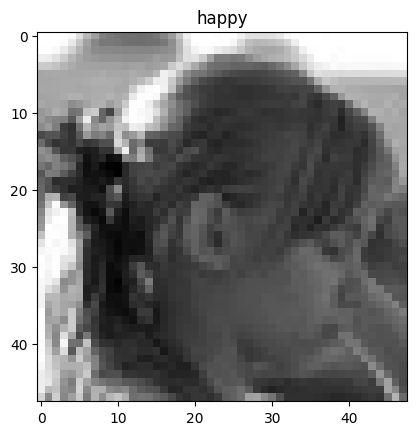

In [ ]:
# Install required packages
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"Failed to install {package}")

# Install imagehash for duplicate detection
install_package("imagehash")


In [ ]:
# Data Preprocessing: Duplicate Detection and Removal
import imagehash
from PIL import Image
import os
import shutil

def detect_and_remove_duplicates(dataset_path):
    """
    Detect and remove duplicate images from the dataset
    """
    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return
    
    # Create cleaned dataset directory
    cleaned_path = dataset_path.replace('train', 'train_cleaned')
    if not os.path.exists(cleaned_path):
        shutil.copytree(dataset_path, cleaned_path)
        print(f"Dataset copied to {cleaned_path}")
    
    total_duplicates = 0
    
    for class_name in os.listdir(cleaned_path):
        class_path = os.path.join(cleaned_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
            
        print(f"Checking class: {class_name}")
        
        hashes = {}
        duplicates = []
        
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            try:
                img = Image.open(file_path)
                h = imagehash.average_hash(img)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
                
            if h in hashes:
                duplicates.append(file_path)
            else:
                hashes[h] = file_path
        
        # Remove duplicates
        for dup in duplicates:
            os.remove(dup)
            
        total_duplicates += len(duplicates)
        print(f"Class {class_name}: {len(duplicates)} duplicates removed")
    
    print(f"\nTotal duplicates removed: {total_duplicates}")
    return cleaned_path

# Run duplicate detection
if os.path.exists(train_folder):
    cleaned_train_path = detect_and_remove_duplicates(train_folder)
else:
    print("Train folder not found. Skipping duplicate detection.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 23.4 MB/s eta 0:00:00


In [ ]:
# Data Preprocessing: Remove Corrupted Images
import cv2
import numpy as np

def remove_corrupted_images(dataset_path):
    """
    Remove completely black or corrupted images from the dataset
    """
    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return
    
    removed_count = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            
            try:
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    os.remove(file_path)
                    removed_count += 1
                    print(f"Removed corrupted image: {file_path}")
                    continue
                
                # Check if all pixels are zero (completely black)
                if np.all(img == 0):
                    os.remove(file_path)
                    removed_count += 1
                    print(f"Removed black image: {file_path}")
                    
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                try:
                    os.remove(file_path)
                    removed_count += 1
                except:
                    pass
    
    print(f"Total corrupted images removed: {removed_count}")

# Run corrupted image removal
if 'cleaned_train_path' in locals() and os.path.exists(cleaned_train_path):
    remove_corrupted_images(cleaned_train_path)
elif os.path.exists(train_folder):
    remove_corrupted_images(train_folder)
else:
    print("No dataset found for corrupted image removal.")


Duplicate found: Training_50102721.jpg
Duplicate found: Training_79860018.jpg
Duplicate found: Training_89020724.jpg
Duplicate found: Training_91676721.jpg
Duplicate found: Training_8721825.jpg
Duplicate found: Training_73057152.jpg
Duplicate found: Training_26894881.jpg
Duplicate found: Training_30679185.jpg
Duplicate found: Training_18739978.jpg
Duplicate found: Training_85603585.jpg
Duplicate found: Training_70378996.jpg
Duplicate found: Training_54825179.jpg
Duplicate found: Training_13014130.jpg
Duplicate found: Training_44476421.jpg
Duplicate found: Training_33044906.jpg
Duplicate found: Training_14674275.jpg
Duplicate found: Training_12195505.jpg
Duplicate found: Training_70035377.jpg
Duplicate found: Training_18037273.jpg
Duplicate found: Training_32165743.jpg
Duplicate found: Training_63887665.jpg
Duplicate found: Training_11569849.jpg
Duplicate found: Training_10235859.jpg
Duplicate found: Training_20061962.jpg
Duplicate found: Training_1916256.jpg
Duplicate found: Training_9

In [ ]:
# Data Augmentation for Class Balancing
import torch
from torchvision import transforms
from PIL import Image
import random
import shutil

def augment_minority_class(dataset_path, target_class='disgust', target_count=2656):
    """
    Augment the minority class to balance the dataset
    """
    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return dataset_path
    
    class_path = os.path.join(dataset_path, target_class)
    if not os.path.exists(class_path):
        print(f"Class {target_class} not found!")
        return dataset_path
    
    # Check current count
    current_count = len(os.listdir(class_path))
    print(f"Current {target_class} count: {current_count}")
    
    if current_count >= target_count:
        print(f"Class {target_class} already has sufficient samples")
        return dataset_path
    
    # Create temporary directory for augmented images
    temp_aug_dir = os.path.join(os.path.dirname(dataset_path), f"temp_aug_{target_class}")
    os.makedirs(temp_aug_dir, exist_ok=True)
    
    # Define augmentation transforms
    augment_transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(CONFIG['image_size'], scale=(0.85, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
        transforms.ToTensor(),
        transforms.ToPILImage()
    ])
    
    # Get existing images
    existing_images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
    
    # Generate augmented images
    generated_count = 0
    while current_count < target_count:
        img_path = random.choice(existing_images)
        
        try:
            img = Image.open(img_path).convert('L')
            augmented_img = augment_transform(img)
            
            save_name = f"aug_{target_class}_{generated_count:05d}.jpg"
            save_path = os.path.join(temp_aug_dir, save_name)
            augmented_img.save(save_path)
            
            generated_count += 1
            current_count += 1
            
        except Exception as e:
            print(f"Error augmenting {img_path}: {e}")
            break
    
    # Move augmented images to the class directory
    for f in os.listdir(temp_aug_dir):
        shutil.move(os.path.join(temp_aug_dir, f), class_path)
    
    # Clean up temporary directory
    shutil.rmtree(temp_aug_dir)
    
    print(f"Generated {generated_count} augmented images for {target_class}")
    print(f"Final {target_class} count: {len(os.listdir(class_path))}")
    
    return dataset_path

# Run augmentation
if 'cleaned_train_path' in locals() and os.path.exists(cleaned_train_path):
    final_dataset_path = augment_minority_class(cleaned_train_path)
elif os.path.exists(train_folder):
    final_dataset_path = augment_minority_class(train_folder)
else:
    print("No dataset found for augmentation.")


Dataset copied to working directory


In [ ]:
# Final Dataset Statistics
import os
from collections import Counter

def get_dataset_stats(dataset_path):
    """
    Get statistics about the processed dataset
    """
    if not os.path.exists(dataset_path):
        print(f"Dataset path {dataset_path} does not exist!")
        return
    
    counts = {}
    total_images = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            counts[class_name] = count
            total_images += count
    
    print("Final dataset statistics:")
    print("-" * 30)
    for emotion, count in counts.items():
        print(f"{emotion:12}: {count:5} images")
    
    print("-" * 30)
    print(f"{'Total':12}: {total_images:5} images")
    
    return counts

# Get final statistics
if 'final_dataset_path' in locals() and os.path.exists(final_dataset_path):
    final_stats = get_dataset_stats(final_dataset_path)
elif 'cleaned_train_path' in locals() and os.path.exists(cleaned_train_path):
    final_stats = get_dataset_stats(cleaned_train_path)
elif os.path.exists(train_folder):
    final_stats = get_dataset_stats(train_folder)
else:
    print("No dataset found for statistics.")


Checking class: sad
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_69378971.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_3714490.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_8083052.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_22658025.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_42888009.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_16130451.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_70035377.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_74136619.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_7587826.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_6736373.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_50600363.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_6716869.jpg
Removed duplicate: /kaggle/working/train_cleaned/sad/Training_67405401.jpg
Removed du

In [ ]:
# Data Loading and Preprocessing
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_data_loaders(train_path, test_path, batch_size=64):
    """
    Create PyTorch data loaders for training and testing
    """
    # Define transformations
    data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Create datasets
    try:
        train_dataset = datasets.ImageFolder(train_path, transform=data_transforms)
        test_dataset = datasets.ImageFolder(test_path, transform=data_transforms)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=2
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=2
        )
        
        print("Data loaders created successfully!")
        print(f"Training samples: {len(train_dataset)}")
        print(f"Testing samples: {len(test_dataset)}")
        print(f"Classes: {train_dataset.classes}")
        print(f"Number of batches (train): {len(train_loader)}")
        print(f"Number of batches (test): {len(test_loader)}")
        
        return train_loader, test_loader, train_dataset, test_dataset
        
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        return None, None, None, None

# Create data loaders
if 'final_dataset_path' in locals() and os.path.exists(final_dataset_path):
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        final_dataset_path, test_folder, CONFIG['batch_size']
    )
elif os.path.exists(train_folder) and os.path.exists(test_folder):
    train_loader, test_loader, train_dataset, test_dataset = create_data_loaders(
        train_folder, test_folder, CONFIG['batch_size']
    )
else:
    print("Cannot create data loaders: Dataset paths not found.")

Removed completely black image: /kaggle/working/train_cleaned/sad/Training_48621797.jpg
Removed completely black image: /kaggle/working/train_cleaned/angry/Training_32571770.jpg
Removed completely black image: /kaggle/working/train_cleaned/neutral/Training_89335926.jpg
Removed completely black image: /kaggle/working/train_cleaned/surprise/Training_48403842.jpg
Removed completely black image: /kaggle/working/train_cleaned/happy/Training_87607167.jpg


Class: sad


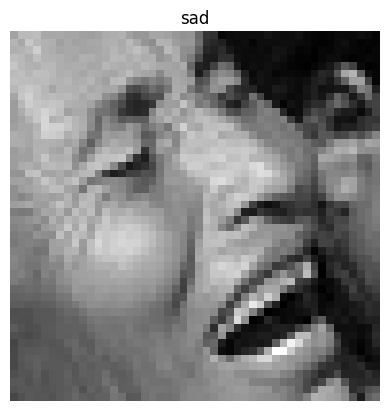

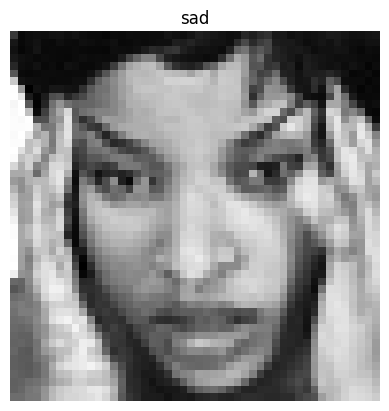

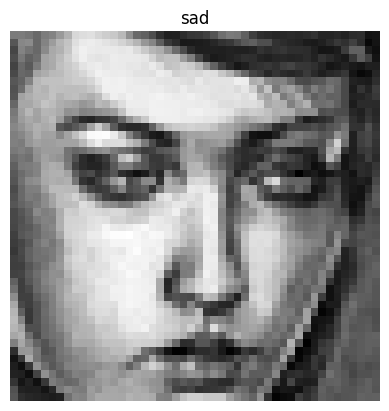

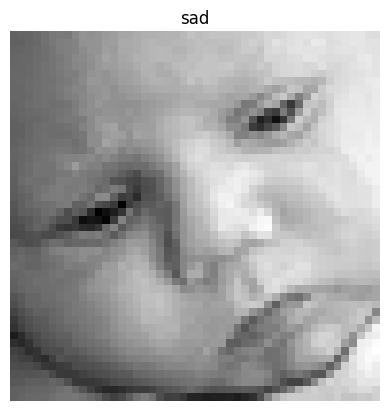

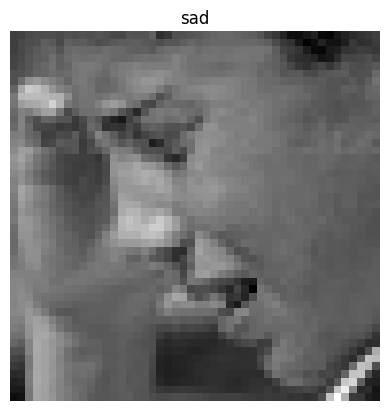

Class: fear


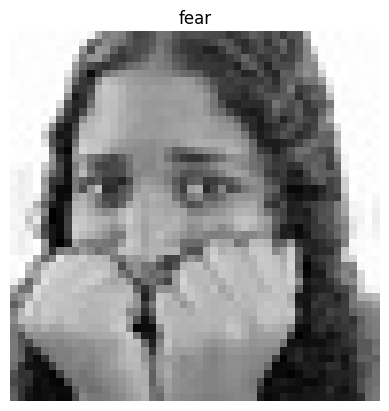

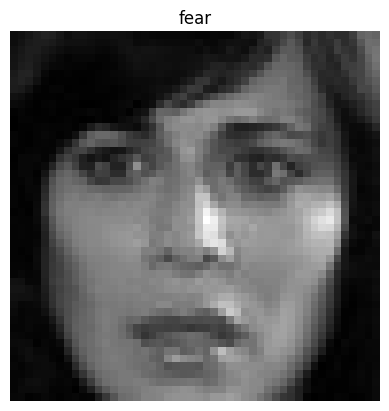

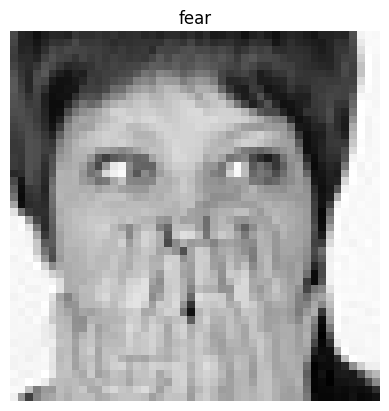

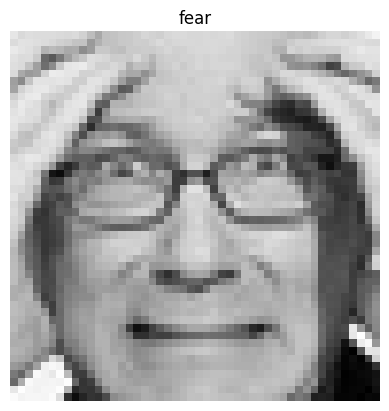

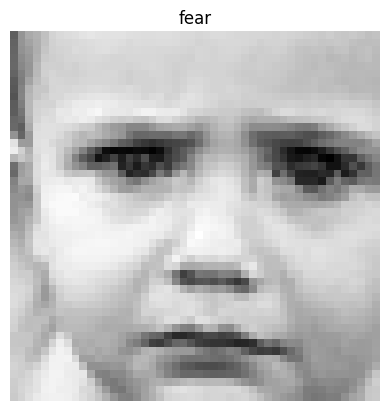

Class: angry


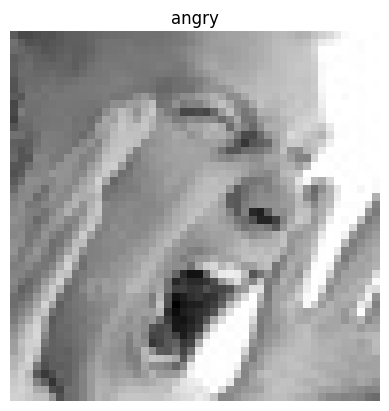

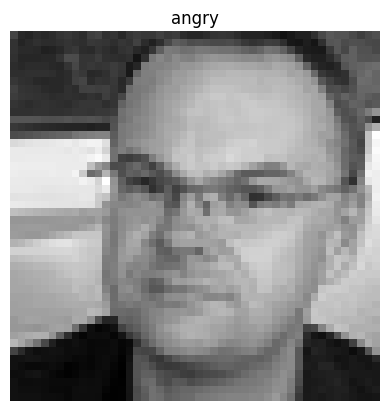

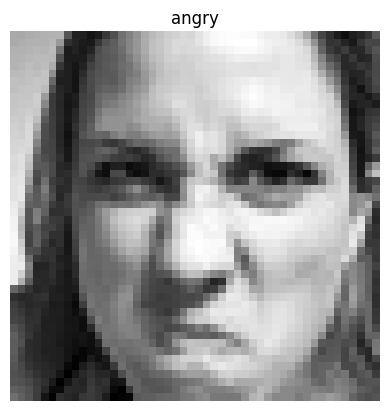

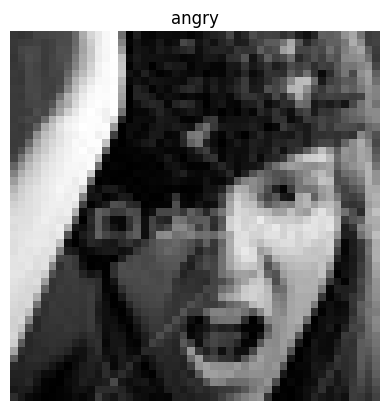

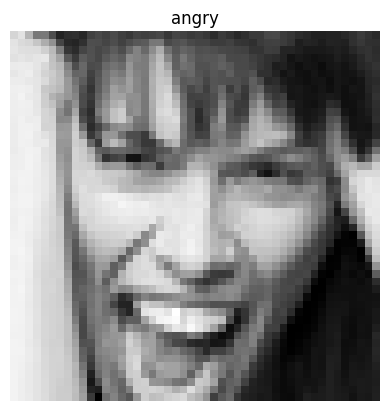

Class: neutral


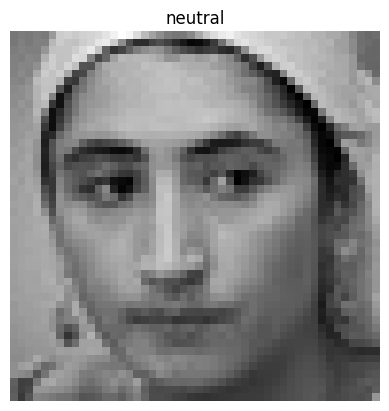

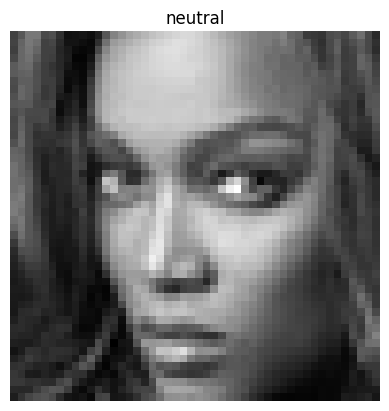

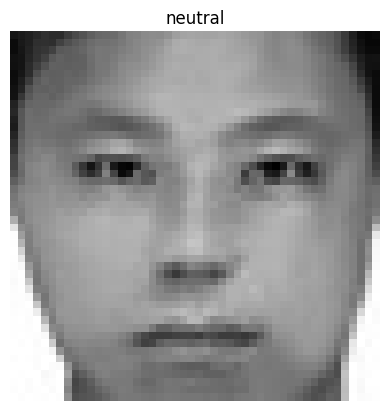

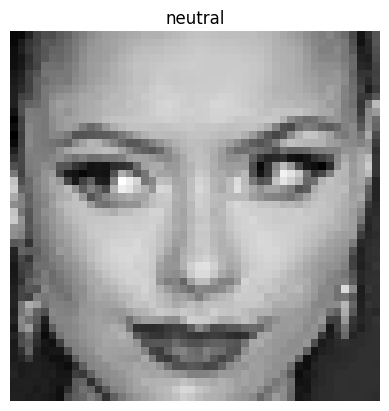

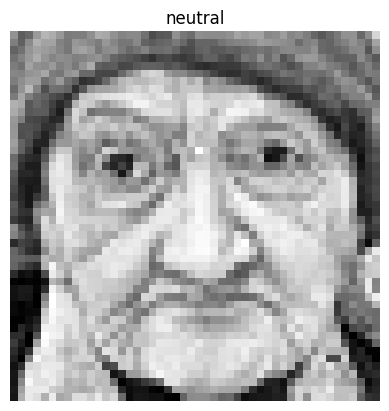

Class: surprise


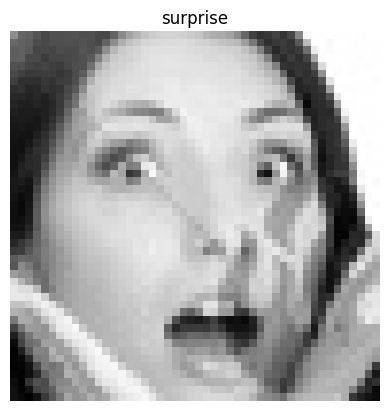

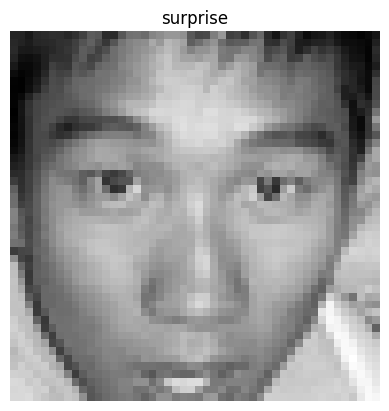

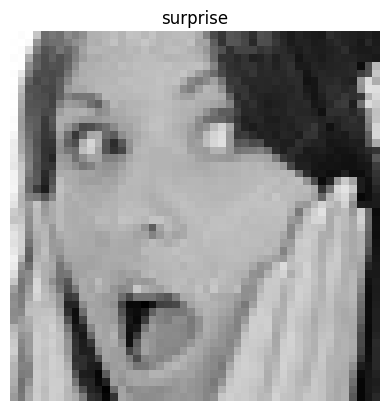

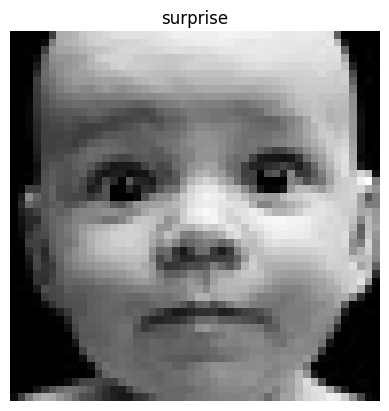

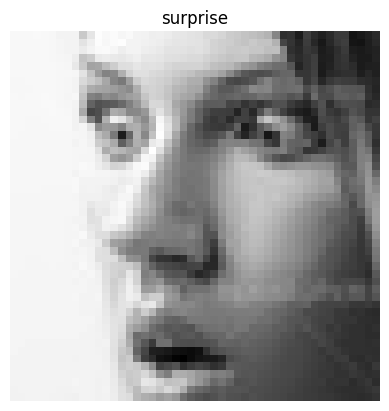

Class: happy


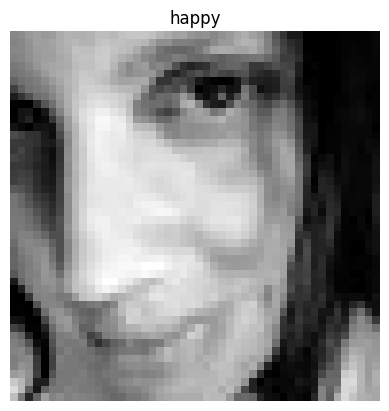

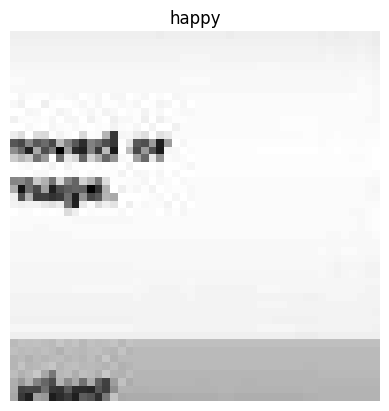

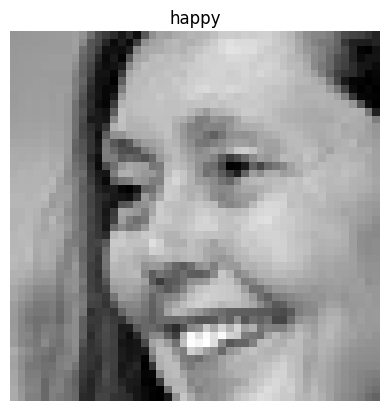

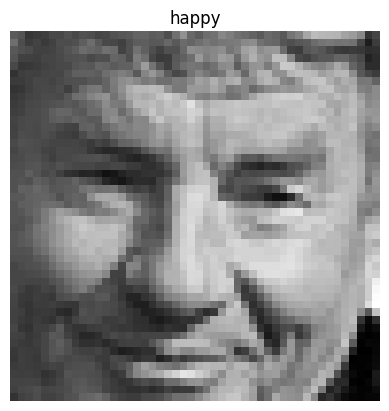

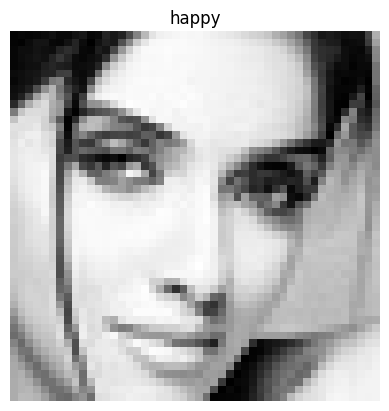

Class: disgust


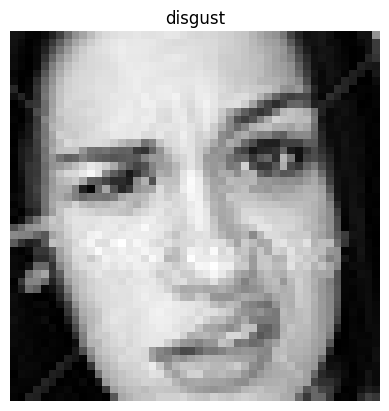

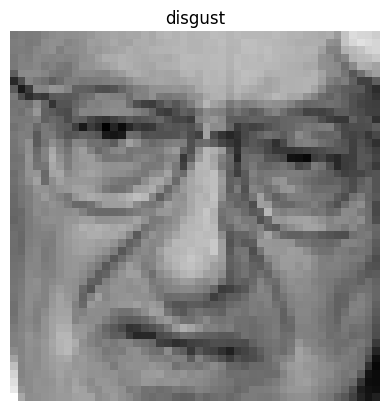

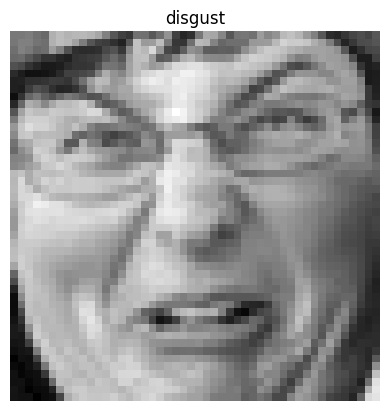

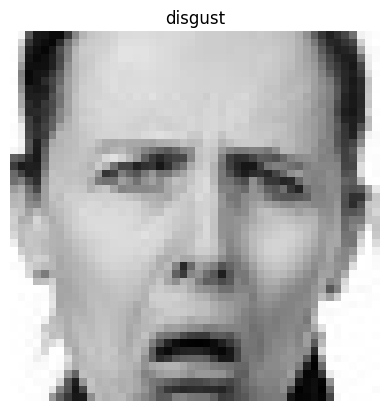

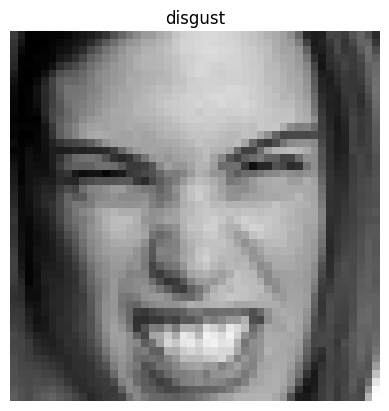

In [ ]:
# CNN Model Definition
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    """
    Convolutional Neural Network for emotion classification
    """
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten and fully connected layers
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize model
model = EmotionCNN(num_classes=7)
print("Model initialized successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


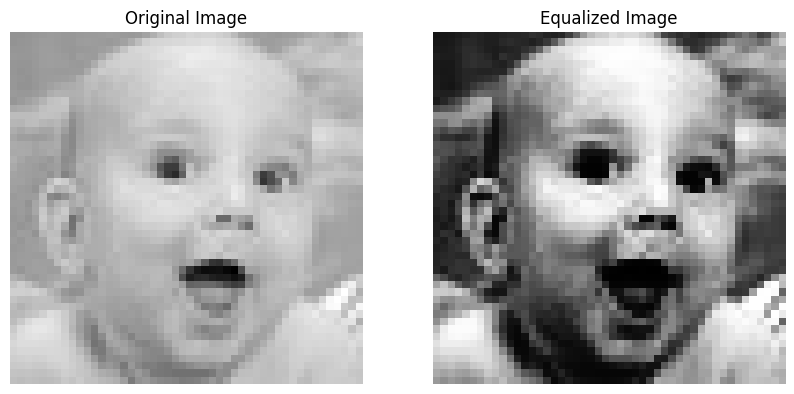

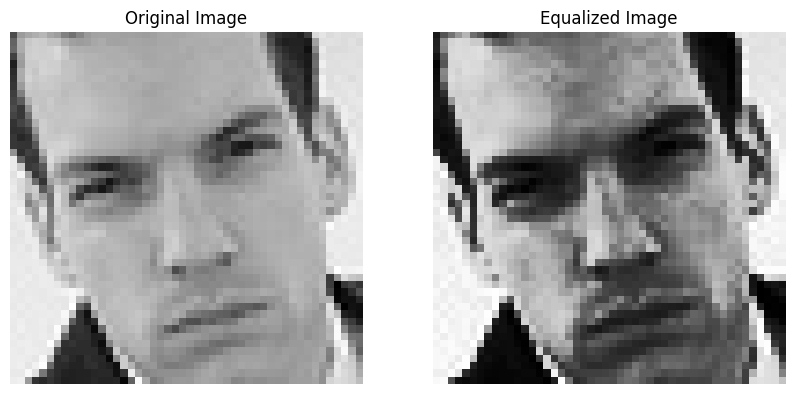

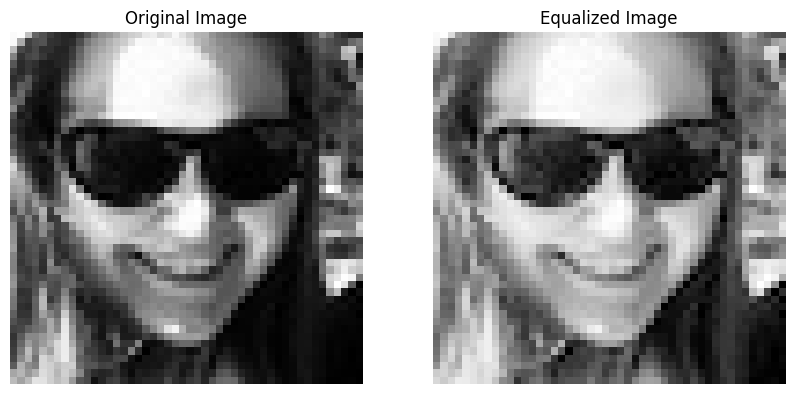

In [ ]:
# Model Training
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001):
    """
    Train the emotion classification model
    """
    if train_loader is None:
        print("No training data available!")
        return None, None
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    print(f"Training on {device}")
    print(f"Number of epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    
    # Training history
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    print("Training completed!")
    return train_losses, train_accuracies

# Train the model
if train_loader is not None:
    train_losses, train_accuracies = train_model(
        model, train_loader, test_loader, 
        CONFIG['num_epochs'], CONFIG['learning_rate']
    )
else:
    print("Cannot train model: No training data available.")

In [ ]:
# Model Evaluation
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, class_names):
    """
    Evaluate the trained model on test data
    """
    if test_loader is None:
        print("No test data available!")
        return
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    all_labels = []
    all_predictions = []
    
    print("Evaluating model on test set...")
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Score: {f1:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, f1

# Evaluate the model
if test_loader is not None and train_dataset is not None:
    accuracy, f1_score = evaluate_model(model, test_loader, train_dataset.classes)
else:
    print("Cannot evaluate model: No test data available.")


{'sad': 4711, 'fear': 3873, 'angry': 3816, 'neutral': 4861, 'surprise': 2656, 'happy': 7071, 'disgust': 379}


In [ ]:
import os
import cv2
import numpy as np
import random
import shutil
import torch
from torchvision import transforms
from PIL import Image

# Define paths
dataset_path = "/kaggle/working/train_cleaned"
disgust_path = os.path.join(dataset_path, "disgust")
augmented_disgust_path = os.path.join("/kaggle/working", "augmented_disgust_pytorch")

# Create a directory to save augmented images
os.makedirs(augmented_disgust_path, exist_ok=True)

# Data augmentation transforms using PyTorch
# These transforms are similar to the ones used with Keras's ImageDataGenerator
augment_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(48, scale=(0.85, 1.0)), # Assuming images are 48x48
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.15),
    transforms.ToTensor(), # Convert to PyTorch tensor
    transforms.ToPILImage() # Convert back to PIL Image for saving
])


# Calculate the target number of images (e.g., aiming for a number closer to the next smallest class)
# Using the same target as before for comparison
target_count = 2656

# Get the list of existing disgust image paths
disgust_image_paths = [os.path.join(disgust_path, f) for f in os.listdir(disgust_path) if os.path.isfile(os.path.join(disgust_path, f))]

# Generate augmented images until the target count is reached
count = len(disgust_image_paths)
generated_count = 0

while count < target_count:
    if not disgust_image_paths:
        print("No images found in the disgust directory for augmentation.")
        break

    img_path = random.choice(disgust_image_paths)
    try:
        # Open image using PIL for torchvision transforms
        img = Image.open(img_path).convert('L') # Convert to grayscale

        # Apply augmentation
        augmented_img = augment_transform(img)

        # Save the augmented image
        save_name = f"aug_disgust_{generated_count:05d}.jpg"
        save_path = os.path.join(augmented_disgust_path, save_name)
        augmented_img.save(save_path)

        generated_count += 1
        count += 1

        # Optional: Generate multiple augmented images per original image
        if generated_count % 5 == 0: # Generate 5 augmented images per original image on average
             pass

    except Exception as e:
        print(f"Error during augmentation of {img_path}: {e}")
        # Remove the problematic image path to avoid repeated errors
        if img_path in disgust_image_paths:
            disgust_image_paths.remove(img_path)


print(f"Generated {generated_count} augmented images for the disgust class.")

# Move the augmented images to the original disgust folder
for f in os.listdir(augmented_disgust_path):
    shutil.move(os.path.join(augmented_disgust_path, f), disgust_path)

# Clean up the temporary directory
shutil.rmtree(augmented_disgust_path)

print("Augmentation complete and images moved.")

# Verify the new count
root = "/kaggle/working/train_cleaned"
counts_after_augmentation = {cls: len(os.listdir(os.path.join(root, cls))) for cls in os.listdir(root)}
print("Counts after augmentation:", counts_after_augmentation)

Generated 2277 augmented images for the disgust class.
Augmentation complete and images moved.
Counts after augmentation: {'sad': 4711, 'fear': 3873, 'angry': 3816, 'neutral': 4861, 'surprise': 2656, 'happy': 7071, 'disgust': 2656}


In [ ]:
# Model Saving and Loading
import torch

def save_model(model, filepath='emotion_model.pth'):
    """
    Save the trained model
    """
    try:
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_class': model.__class__.__name__,
            'num_classes': 7
        }, filepath)
        print(f"Model saved successfully to {filepath}")
    except Exception as e:
        print(f"Error saving model: {e}")

def load_model(filepath='emotion_model.pth'):
    """
    Load a saved model
    """
    try:
        checkpoint = torch.load(filepath, map_location='cpu')
        model = EmotionCNN(num_classes=checkpoint['num_classes'])
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded successfully from {filepath}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Save the trained model
if 'model' in locals():
    save_model(model)
else:
    print("No trained model available to save.")

Number of training samples: 29644
Number of testing samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of batches in train_loader: 464
Number of batches in test_loader: 113


In [ ]:
# Prediction Function for New Images
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

def predict_emotion(model, image_path, class_names):
    """
    Predict emotion from a single image
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    
    # Define the same transforms used during training
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('L')
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image_tensor = image_tensor.to(device)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        # Display result
        print(f"Predicted emotion: {class_names[predicted_class]}")
        print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
        
        # Show all class probabilities
        print("\nAll class probabilities:")
        for i, prob in enumerate(probabilities[0]):
            print(f"{class_names[i]:12}: {prob:.4f} ({prob*100:.2f}%)")
        
        return predicted_class, confidence
        
    except Exception as e:
        print(f"Error predicting emotion: {e}")
        return None

# Example usage (uncomment to test with a sample image)
# if 'model' in locals() and train_dataset is not None:
#     sample_image_path = "path/to/your/image.jpg"  # Replace with actual image path
#     predict_emotion(model, sample_image_path, train_dataset.classes)

In [ ]:
# Requirements and Dependencies
print("Required Python packages:")
print("=" * 40)
print("torch>=1.9.0")
print("torchvision>=0.10.0")
print("opencv-python>=4.5.0")
print("Pillow>=8.0.0")
print("matplotlib>=3.3.0")
print("seaborn>=0.11.0")
print("scikit-learn>=1.0.0")
print("numpy>=1.21.0")
print("imagehash>=4.3.0")
print("=" * 40)
print("\nTo install all requirements, run:")
print("pip install torch torchvision opencv-python Pillow matplotlib seaborn scikit-learn numpy imagehash")

Training on cuda
Epoch [1/20], Loss: 1.5184
Epoch [2/20], Loss: 1.2157
Epoch [3/20], Loss: 1.0733
Epoch [4/20], Loss: 0.9448
Epoch [5/20], Loss: 0.8061
Epoch [6/20], Loss: 0.6458
Epoch [7/20], Loss: 0.4667
Epoch [8/20], Loss: 0.3022
Epoch [9/20], Loss: 0.1945
Epoch [10/20], Loss: 0.1344
Epoch [11/20], Loss: 0.1121
Epoch [12/20], Loss: 0.0885
Epoch [13/20], Loss: 0.0762
Epoch [14/20], Loss: 0.0710
Epoch [15/20], Loss: 0.0764
Epoch [16/20], Loss: 0.0686
Epoch [17/20], Loss: 0.0642
Epoch [18/20], Loss: 0.0570
Epoch [19/20], Loss: 0.0671
Epoch [20/20], Loss: 0.0484
Training finished


In [ ]:
# Project Information and Usage Instructions
print("EMOTION CLASSIFICATION PROJECT")
print("=" * 50)
print("This notebook implements a CNN-based emotion classification system")
print("using the FER-2013 dataset.")
print()
print("DATASET:")
print("- FER-2013 (Facial Expression Recognition 2013)")
print("- 7 emotion classes: angry, disgust, fear, happy, neutral, sad, surprise")
print("- Images are 48x48 grayscale")
print()
print("MODEL ARCHITECTURE:")
print("- 3 Convolutional layers with ReLU activation")
print("- Max pooling after each conv layer")
print("- 2 Fully connected layers with dropout")
print("- Output: 7 classes")
print()
print("PREPROCESSING:")
print("- Duplicate image removal")
print("- Corrupted image removal")
print("- Data augmentation for class balancing")
print("- Image normalization")
print()
print("USAGE:")
print("1. Download FER-2013 dataset")
print("2. Extract to './data/' directory")
print("3. Run all cells in order")
print("4. Model will be trained and evaluated automatically")
print()
print("For prediction on new images, use the predict_emotion() function")
print("=" * 50)

Accuracy on the test set: 0.5698
F1-score on the test set: 0.5744
